# Hyper-Parameter Optimization Using Keras on Fashion-MNIST DataSet

## Introduction
The Fashion-MNIST dataset is a collection of images of fashion items, like T-shirts, dresses, shoes etc. It can be used as drop-in replacement for the original MNIST digits dataset as it shares the same image size (28x28x1— grayscale) and has 60,000 training and 10,000 testing images. It has 10 categories of output labels: [0: T-shirt/top, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle Boot].

### Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visualkeras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPooling2D,
    Flatten,
    BatchNormalization,
)
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from time import time
from keras import backend as K

### Loading the Fashion MNIST DataSet from Keras

In [2]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

print(type(train_data))
print(type(test_data))

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Data Visualization

In [4]:
print(test_data[0])
print(test_labels[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   1   0   0   7   0  37   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   

In [5]:
df = pd.DataFrame(test_labels, columns=["key"])
d_f = df.groupby("key", sort=True)["key"].count()
d_f

key
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: key, dtype: int64

There are 10 classes with the same amount of samples in the fashion_mnist dataset. Let's print their random examples.

In [6]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

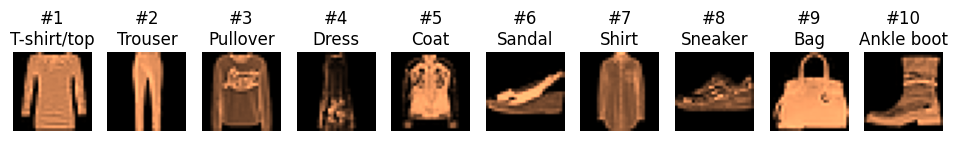

In [7]:
sorter = np.argsort(test_labels)
numbers = np.array([i for i in range(10)])
indices = sorter[np.searchsorted(test_labels, numbers, sorter=sorter)]
test_images = test_data[indices]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap="copper")
    plt.title(f"#{i+1}\n{class_names[i]}")
    plt.axis("off")
plt.show()

## Architecture 1 (5 Dense Layers)
In this section, the selection of optimal hyperparameters will be carried out on a simple model composed only of Dense layers whose quantity can vary from 3 to 5.

### Data Normalization

In [8]:
train_norm = train_data.astype("float32") / 255
test_norm = test_data.astype("float32") / 255

train_norm = train_norm.reshape([-1, train_data[0].shape[0] * train_data[0].shape[1]])
test_norm = test_norm.reshape([-1, train_data[0].shape[0] * train_data[0].shape[1]])

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

### Quality Metrics

In [9]:
def recall_m(truth, predict):
    true_positives = K.sum(K.round(K.clip(truth * predict, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(truth, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(truth, predict):
    true_positives = K.sum(K.round(K.clip(truth * predict, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predict, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(truth, predict):
    precision = precision_m(truth, predict)
    recall = recall_m(truth, predict)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Custom Model Constructor

In [10]:
def construct_model(
    optimizer,
    learning_rate,
    activation,
    dropout_rate,
    initializer,
    units_l1,
    units_l2,
    units_l3,
    units_l4,
    units_l5,
):
    K.clear_session()
    model = Sequential()

    model.add(
        Dense(
            units_l1,
            kernel_initializer=initializer,
            activation=activation,
            input_shape=(train_norm.shape[1],),
        )
    )
    model.add(Dropout(dropout_rate))

    model.add(Dense(units_l2, kernel_initializer=initializer, activation=activation))
    model.add(Dropout(dropout_rate))

    if units_l3 > 0:
        model.add(
            Dense(units_l3, kernel_initializer=initializer, activation=activation)
        )
        model.add(Dropout(dropout_rate))

    if units_l4 > 0:
        model.add(
            Dense(units_l4, kernel_initializer=initializer, activation=activation)
        )
        model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))  # 'softmax' if more than two classes
    # 10 neurons- on exit layer because of 'categorical' labels format
    model.compile(
        loss="categorical_crossentropy",  # when there are more than two classes
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy", f1_m],
    )
    return model

### Plotter of Learning Curves

In [11]:
def plot_results(history):
    history_dict = history.history

    epochs = range(1, len(history_dict["accuracy"]) + 1)

    plt.plot(epochs, history_dict["loss"], "bo", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, history_dict["accuracy"], "bo", label="Training acc")
    plt.plot(epochs, history_dict["val_accuracy"], "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    plt.plot(epochs, history_dict["f1_m"], "bo", label="Training F1 Score")
    plt.plot(epochs, history_dict["val_f1_m"], "b", label="Validation F1 Score")
    plt.title("Training and validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

### Model Evaluator
By default, it contains very simple hyperparameters that will be optimized in the process.

In [12]:
def evaluate_model(
    optimizer=SGD,
    learning_rate=0.003,
    activation="sigmoid",
    dropout_rate=0,
    initializer="glorot_uniform",
    units_l1=784,
    units_l2=784,
    units_l3=0,
    units_l4=0,
    units_l5=0,
    epochs=100,
    batch_size=64,
    constructor=construct_model,
    input_x=train_norm,
    test_x=test_norm,
):
    start = time()
    model = constructor(
        optimizer,
        learning_rate,
        activation,
        dropout_rate,
        initializer,
        units_l1,
        units_l2,
        units_l3,
        units_l4,
        units_l5,
    )
    history = model.fit(
        x=input_x,
        y=train_labels,
        epochs=epochs,
        verbose=1,
        batch_size=batch_size,
        validation_data=(test_x, test_labels),
    )

    results = model.evaluate(test_x, test_labels)
    print(
        f"\nModel's results on test data after {epochs} epochs:\nAccuracy -> {results[1]*100:.2f}%\nF1 Score -> {results[2]*100:.2f}%"
    )
    print(f"Duration -> {time()-start:.1f}s")

    plot_results(history)

    return model, history

### Evaluation of a Simple Basic Model

Epoch 1/100
938/938 [==============================] - 5s 5ms/step - loss: 2.2548 - accuracy: 0.2403 - f1_m: 0.0000e+00 - val_loss: 2.2000 - val_accuracy: 0.2804 - val_f1_m: 0.0000e+00
Epoch 2/100
938/938 [==============================] - 5s 6ms/step - loss: 2.1336 - accuracy: 0.4671 - f1_m: 0.0000e+00 - val_loss: 2.0646 - val_accuracy: 0.5822 - val_f1_m: 0.0000e+00
Epoch 3/100
938/938 [==============================] - 4s 4ms/step - loss: 1.9791 - accuracy: 0.5530 - f1_m: 0.0000e+00 - val_loss: 1.8894 - val_accuracy: 0.5676 - val_f1_m: 0.0000e+00
Epoch 4/100
938/938 [==============================] - 5s 5ms/step - loss: 1.7836 - accuracy: 0.5900 - f1_m: 0.0000e+00 - val_loss: 1.6821 - val_accuracy: 0.6408 - val_f1_m: 0.0000e+00
Epoch 5/100
938/938 [==============================] - 8s 9ms/step - loss: 1.5806 - accuracy: 0.6147 - f1_m: 3.2803e-05 - val_loss: 1.4932 - val_accuracy: 0.6537 - val_f1_m: 0.0000e+00
Epoch 6/100
938/938 [==============================] - 4s 4ms/step - loss: 

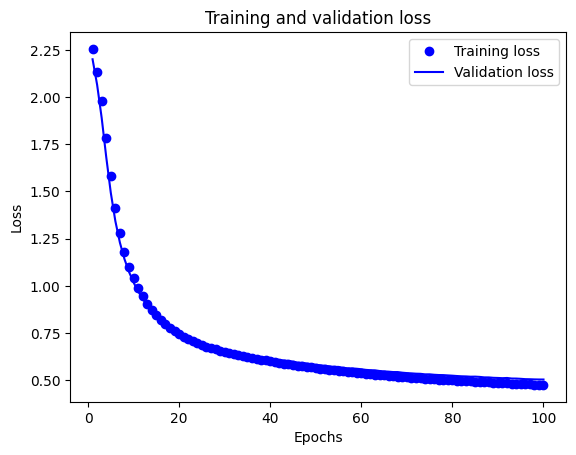

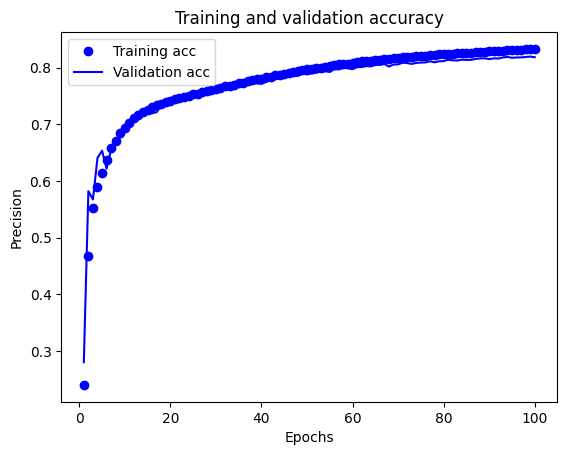

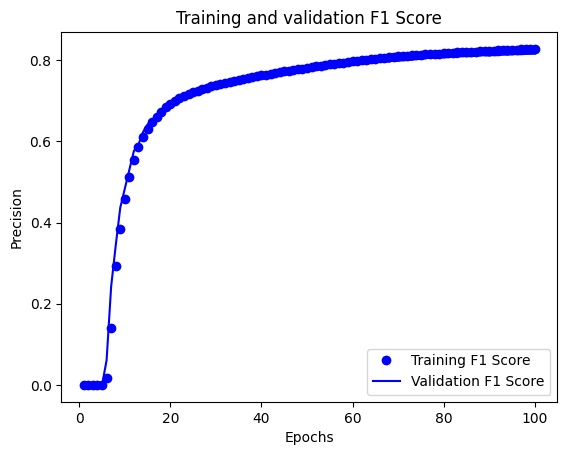

(<keras.src.engine.sequential.Sequential at 0x78a938cd4e50>,
 <keras.src.callbacks.History at 0x78a9374d14b0>)

In [81]:
evaluate_model()

Accuracy and F1 Score are very far from the minimum acceptable 91%. Let's increase the number, introduce droput rate of neurons and change the activation, optimizer and initializer to ReLU, Adam and Lecun Uniform respectively.

Epoch 1/100
469/469 [==============================] - 4s 6ms/step - loss: 0.7848 - accuracy: 0.7403 - f1_m: 0.6687 - val_loss: 0.5070 - val_accuracy: 0.8230 - val_f1_m: 0.8132
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4939 - accuracy: 0.8292 - f1_m: 0.8200 - val_loss: 0.4459 - val_accuracy: 0.8436 - val_f1_m: 0.8391
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4371 - accuracy: 0.8475 - f1_m: 0.8415 - val_loss: 0.4144 - val_accuracy: 0.8528 - val_f1_m: 0.8500
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4029 - accuracy: 0.8576 - f1_m: 0.8551 - val_loss: 0.3971 - val_accuracy: 0.8587 - val_f1_m: 0.8579
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3809 - accuracy: 0.8647 - f1_m: 0.8627 - val_loss: 0.3848 - val_accuracy: 0.8616 - val_f1_m: 0.8619
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3629 - accuracy: 0.8716 - f1_m: 0.8697

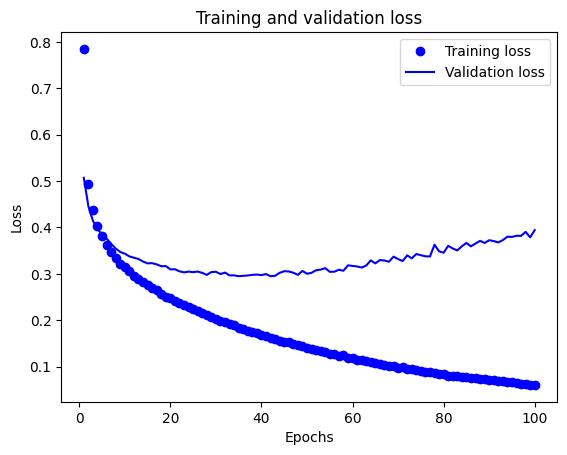

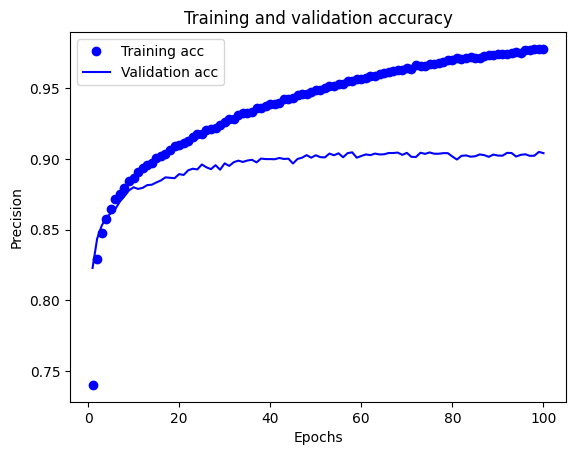

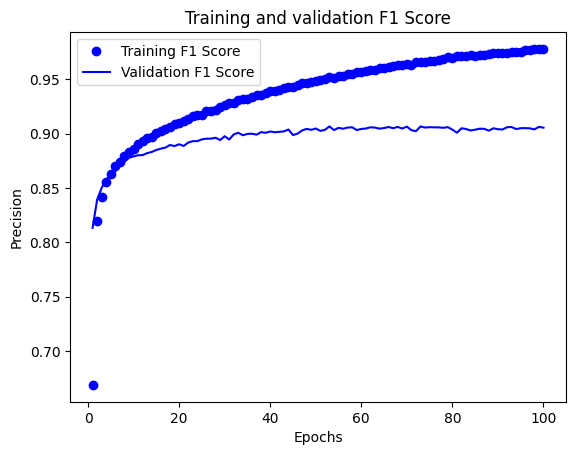

(<keras.src.engine.sequential.Sequential at 0x78a9d8898be0>,
 <keras.src.callbacks.History at 0x78a939b151e0>)

In [83]:
evaluate_model(
    epochs=100,
    batch_size=128,
    units_l1=1024,
    units_l2=1024,
    activation="relu",
    optimizer=Adam,
    learning_rate=0.00005,
    dropout_rate=0.3,
    initializer="lecun_uniform",
)

Now the result is much better, but still below the desired 91%. Also, this model is prone to over fitting after 50 epochs. Let's reduce their number and increase the number of layers from 3 to 5.

Epoch 1/50
469/469 [==============================] - 5s 7ms/step - loss: 0.8649 - accuracy: 0.6945 - f1_m: 0.6282 - val_loss: 0.5133 - val_accuracy: 0.8143 - val_f1_m: 0.8059
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.5021 - accuracy: 0.8218 - f1_m: 0.8144 - val_loss: 0.4417 - val_accuracy: 0.8421 - val_f1_m: 0.8396
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.4324 - accuracy: 0.8446 - f1_m: 0.8422 - val_loss: 0.4028 - val_accuracy: 0.8561 - val_f1_m: 0.8556
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3953 - accuracy: 0.8586 - f1_m: 0.8571 - val_loss: 0.3815 - val_accuracy: 0.8599 - val_f1_m: 0.8615
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3716 - accuracy: 0.8666 - f1_m: 0.8655 - val_loss: 0.3708 - val_accuracy: 0.8660 - val_f1_m: 0.8668
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3486 - accuracy: 0.8732 - f1_m: 0.8736 - val

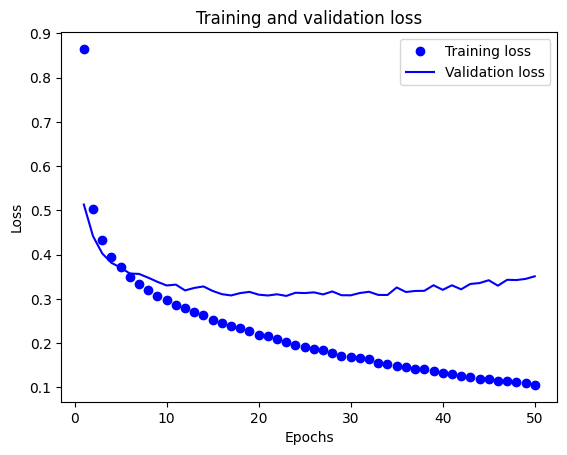

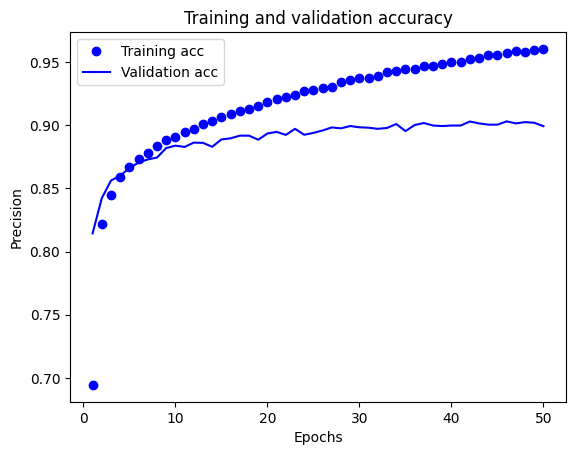

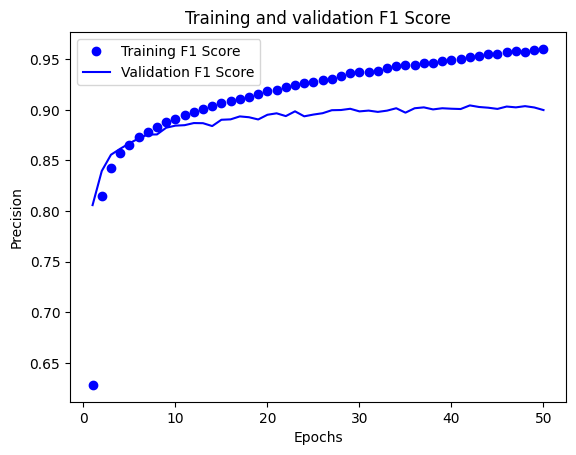

(<keras.src.engine.sequential.Sequential at 0x78a937739f30>,
 <keras.src.callbacks.History at 0x78a9d8679600>)

In [84]:
evaluate_model(
    epochs=50,
    batch_size=128,
    units_l1=1024,
    units_l2=1024,
    units_l3=1024,
    units_l4=1024,
    activation="relu",
    optimizer=Adam,
    learning_rate=0.00005,
    dropout_rate=0.3,
    initializer="lecun_uniform",
)

Increasing only the number of layers reduces the accuracy of the model. It seems very difficult to get accuracy above 91% only with Dense layers. Let's also introduce the Conv2D layers.

## Architecture 2 (6 Conv2D Layers + 3 Dense Layers)

### Custom Model Constructor

In [13]:
def construct_model_new(
    optimizer,
    learning_rate,
    activation,
    dropout_rate,
    initializer,
    units_l1,
    units_l2,
    units_l3,
    units_l4,
    units_l5,
):
    K.clear_session()
    model = Sequential()

    model.add(
        Conv2D(
            units_l1,
            kernel_size=(3, 3),
            activation=activation,
            padding="same",
            input_shape=(train_data[0].shape[0], train_data[0].shape[1], 1),
        )
    )
    model.add(BatchNormalization())
    model.add(Conv2D(units_l1, kernel_size=(3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(units_l2, kernel_size=(3, 3), activation=activation, padding="same")
    )
    model.add(BatchNormalization())
    model.add(Conv2D(units_l2, kernel_size=(3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(units_l3, kernel_size=(3, 3), activation=activation, padding="same")
    )
    model.add(BatchNormalization())
    model.add(Conv2D(units_l3, kernel_size=(3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units_l4, kernel_initializer=initializer, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units_l5, kernel_initializer=initializer, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy", f1_m],
    )
    return model

### Normalization without flattening the DataSet

In [14]:
train_norm_new = train_data.astype("float32") / 255
test_norm_new = test_data.astype("float32") / 255

train_norm_new = np.reshape(
    train_norm_new,
    (train_norm_new.shape[0], train_norm_new.shape[1], train_norm_new.shape[2], 1),
)

test_norm_new = np.reshape(
    test_norm_new,
    (test_norm_new.shape[0], test_norm_new.shape[1], test_norm_new.shape[2], 1),
)

### Evaluating New Model

Epoch 1/20
938/938 [==============================] - 19s 16ms/step - loss: 0.4865 - accuracy: 0.8260 - f1_m: 0.8213 - val_loss: 0.4853 - val_accuracy: 0.8323 - val_f1_m: 0.8329
Epoch 2/20
938/938 [==============================] - 15s 15ms/step - loss: 0.2824 - accuracy: 0.8979 - f1_m: 0.8986 - val_loss: 0.2733 - val_accuracy: 0.8997 - val_f1_m: 0.9017
Epoch 3/20
938/938 [==============================] - 15s 16ms/step - loss: 0.2158 - accuracy: 0.9213 - f1_m: 0.9216 - val_loss: 0.2618 - val_accuracy: 0.9053 - val_f1_m: 0.9052
Epoch 4/20
938/938 [==============================] - 15s 16ms/step - loss: 0.1714 - accuracy: 0.9388 - f1_m: 0.9389 - val_loss: 0.2640 - val_accuracy: 0.9064 - val_f1_m: 0.9081
Epoch 5/20
938/938 [==============================] - 15s 16ms/step - loss: 0.1371 - accuracy: 0.9489 - f1_m: 0.9492 - val_loss: 0.2636 - val_accuracy: 0.9072 - val_f1_m: 0.9088
Epoch 6/20
938/938 [==============================] - 16s 17ms/step - loss: 0.1099 - accuracy: 0.9597 - f1_m: 

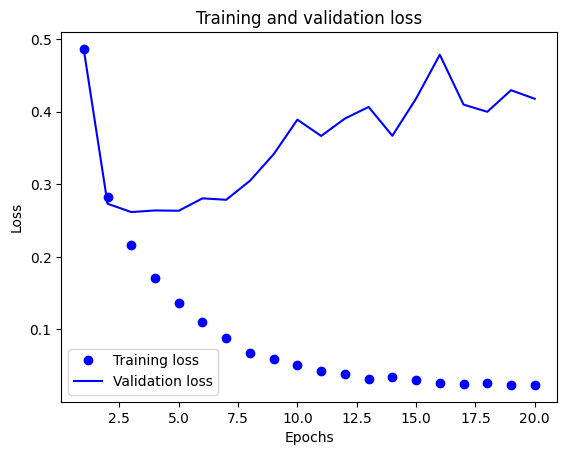

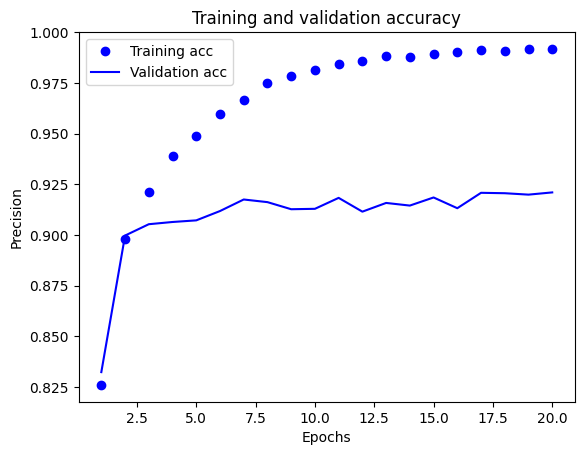

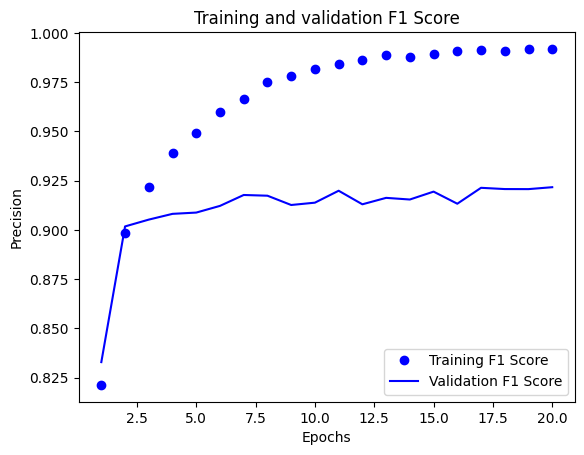

(<keras.src.engine.sequential.Sequential at 0x78a9db6366e0>,
 <keras.src.callbacks.History at 0x78a9d9788f10>)

In [105]:
evaluate_model(constructor=construct_model_new, epochs=20, batch_size=64, units_l1=64, units_l2=128, units_l3=256, units_l4=1024, units_l5=512, activation="relu", optimizer=Adam, learning_rate=0.0001, dropout_rate=0.3, initializer="glorot_uniform", input_x=train_norm_new, test_x=test_norm_new)

Accuracy and F1 Score exceed the minimum acceptable 91%. Let's try to simplify the model to speed up learning.

### Architecture 3 (4 Conv2D Layers + 2 Dense Layers)

### Custom Model Constructor

In [15]:
def construct_model_neo(
    optimizer,
    learning_rate,
    activation,
    dropout_rate,
    initializer,
    units_l1,
    units_l2,
    units_l3,
    units_l4,
    units_l5,
):
    model = Sequential()

    model.add(
        Conv2D(
            units_l1,
            3,
            padding="same",
            activation=activation,
            kernel_initializer=initializer,
            input_shape=(train_data[0].shape[0], train_data[0].shape[1], 1),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(units_l2, 3, padding="same", activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Conv2D(units_l3, 3, padding="same", activation=activation))
    model.add(Conv2D(units_l4, 3, padding="same", activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(units_l5, activation=activation))

    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy", f1_m],
    )
    return model

### Evaluating New Model

Epoch 1/100
469/469 [==============================] - 17s 34ms/step - loss: 0.5379 - accuracy: 0.8062 - f1_m: 0.8060 - val_loss: 0.3665 - val_accuracy: 0.8656 - val_f1_m: 0.8668
Epoch 2/100
469/469 [==============================] - 15s 33ms/step - loss: 0.3689 - accuracy: 0.8622 - f1_m: 0.8627 - val_loss: 0.3128 - val_accuracy: 0.8847 - val_f1_m: 0.8869
Epoch 3/100
469/469 [==============================] - 16s 33ms/step - loss: 0.3191 - accuracy: 0.8801 - f1_m: 0.8808 - val_loss: 0.2955 - val_accuracy: 0.8886 - val_f1_m: 0.8898
Epoch 4/100
469/469 [==============================] - 15s 33ms/step - loss: 0.2927 - accuracy: 0.8911 - f1_m: 0.8915 - val_loss: 0.2769 - val_accuracy: 0.8956 - val_f1_m: 0.8986
Epoch 5/100
469/469 [==============================] - 15s 33ms/step - loss: 0.2765 - accuracy: 0.8972 - f1_m: 0.8974 - val_loss: 0.2672 - val_accuracy: 0.9001 - val_f1_m: 0.9016
Epoch 6/100
469/469 [==============================] - 16s 33ms/step - loss: 0.2562 - accuracy: 0.9034 - 

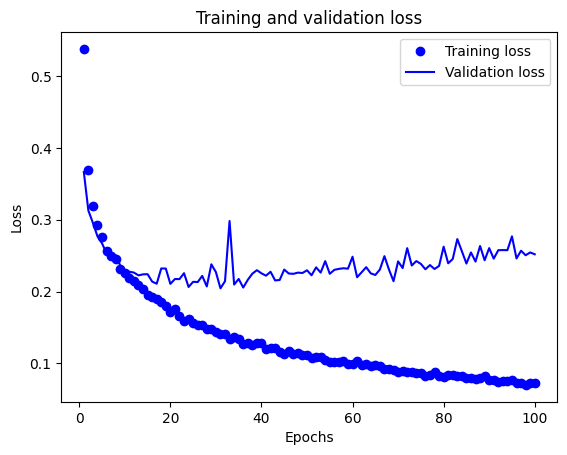

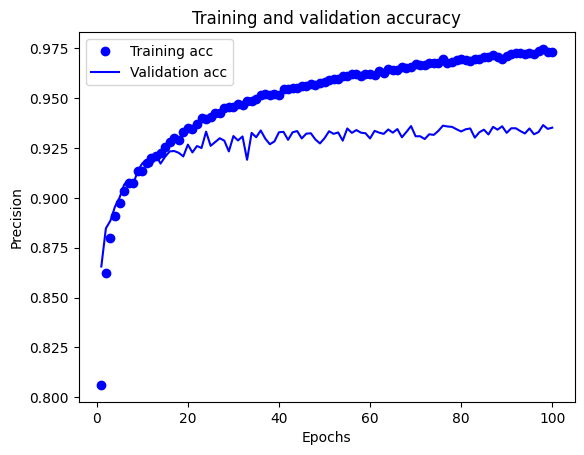

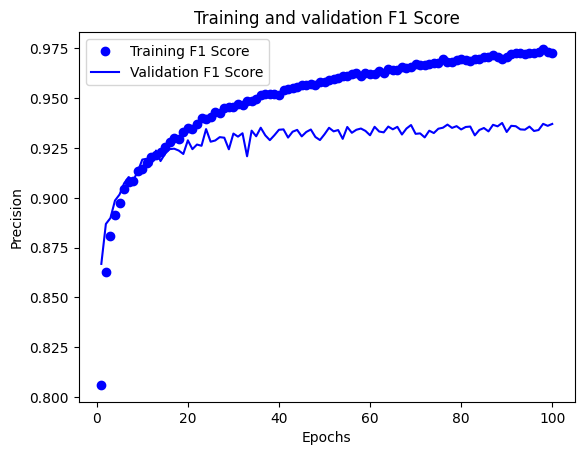

(<keras.src.engine.sequential.Sequential at 0x27023a22a50>,
 <keras.src.callbacks.History at 0x2704c249910>)

In [18]:
evaluate_model(
    constructor=construct_model_neo,
    epochs=100,
    batch_size=128,
    units_l1=32,
    units_l2=64,
    units_l3=128,
    units_l4=128,
    units_l5=512,
    activation="relu",
    optimizer=Adam,
    learning_rate=0.001,
    dropout_rate=0.3,
    initializer="he_normal",
    input_x=train_norm_new,
    test_x=test_norm_new,
)

### Visualization of the Neural Network Architecture

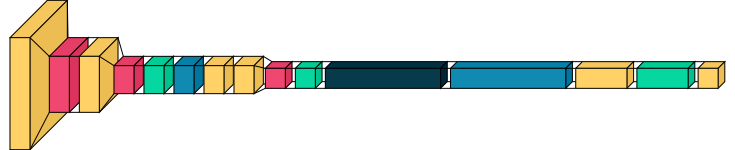

In [20]:
model = construct_model_neo(
    units_l1=32,
    units_l2=64,
    units_l3=128,
    units_l4=128,
    units_l5=512,
    activation="relu",
    optimizer=Adam,
    learning_rate=0.001,
    dropout_rate=0.3,
    initializer="he_normal",
)
visualkeras.layered_view(model)

## Conclusion
The latter model has an accuracy and F1 Score of more than 93.5% based on the test data, which can be considered an acceptable result.